In [1]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [2]:
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import os
import glob
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import classification_common
import joblib

#To ensure reproducibility
np.random.seed(39)

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

In [5]:
# Create/store/load binary image data
if not os.path.isfile(DATA_DIR + 'binary_imgs.npy'):

    dataset_path = "../../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
    img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
    img_filenames.sort()
    print('Number of subjects: %d' % len(img_filenames))

    img_shape = load_img(img_filenames[0]).shape

    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
    masker = masker.fit()

    imgs = masker.transform(img_filenames) # break down into slices if necessary
    imgs = imgs.astype(bool)
    np.save(DATA_DIR + 'binary_imgs', imgs)

else:
    imgs = np.load(DATA_DIR + 'binary_imgs.npy')

print(imgs.shape)

(1401, 228453)


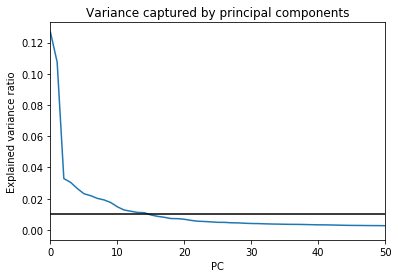

In [9]:
# plot variance explained by components
if not os.path.isfile(DATA_DIR + 'pca_all.joblib'): 
    pca_all = PCA(copy=False)
    X_pc_all = pca_all.fit_transform(imgs)
    joblib.dump(pca_all, DATA_DIR + 'pca_all.joblib') 

else:
    pca_all = joblib.load(DATA_DIR + 'pca_all.joblib') 
    
plt.plot(pca_all.explained_variance_ratio_)
plt.title("Variance captured by principal components")
plt.xlabel("PC")
plt.xlim(0, 50)
plt.axhline(0.01, color="black")
plt.ylabel("Explained variance ratio")
plt.show()

In [3]:
# Calculate 100 PC components
N_PCA = 100
if not os.path.isfile(DATA_DIR + 'binary_imgs_pc_100.npy'):    
    pca = PCA(n_components=N_PCA, copy=False)
    X_pc = pca.fit_transform(imgs)
    np.save(DATA_DIR + 'binary_imgs_pc_100.npy', X_pc)
    
else:
    X_pc = np.load(DATA_DIR + 'binary_imgs_pc_100.npy')
    
X_pc.shape

(1401, 100)

In [4]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [5]:
# sort the outcomes
if not os.path.isfile(DATA_DIR + 'Y_sort_idx.npy'):    
    Y_sort_idx = np.empty(Y.shape, dtype=int)
    for i in range(Y.shape[1]):
        Y_sort_idx[:, i] = np.argsort(Y[:, i])

    # save for consistency in future analysis
    np.save(DATA_DIR + 'Y_sort_idx', Y_sort_idx)
    
else:
    Y_sort_idx = np.load(DATA_DIR + 'Y_sort_idx.npy')
    
print(Y_sort_idx.shape)

(1401, 6)


### Classification

#### 1- Logistic Regression

In [6]:
def run_logistic_regression_clf(X, Y, Y_sort_idx):
    
    estimator = LogisticRegression(random_state = 39, max_iter=20000)
    C = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000] # C = np.logspace(-1, 10, 12)
    grid = {'C': C}
    
    return classification_common.run_classification(X, Y, Y_sort_idx,estimator, grid, "Logistic Regression")


In [7]:
scores_df_lr, best_params_df_lr = run_logistic_regression_clf(X_pc, Y, Y_sort_idx)


Global Cognition

Data % used: 100.0%
Fold-1: Best params: {'C': 100}
Fold-2: Best params: {'C': 100}
Fold-3: Best params: {'C': 10}
Fold-4: Best params: {'C': 100}
Fold-5: Best params: {'C': 10}
Data % used: 60.0%
Fold-1: Best params: {'C': 10}
Fold-2: Best params: {'C': 10}
Fold-3: Best params: {'C': 1}
Fold-4: Best params: {'C': 100}
Fold-5: Best params: {'C': 1000}
Data % used: 40.0%
Fold-1: Best params: {'C': 100}
Fold-2: Best params: {'C': 100}
Fold-3: Best params: {'C': 1000}
Fold-4: Best params: {'C': 100}
Fold-5: Best params: {'C': 100}
Data % used: 20.0%
Fold-1: Best params: {'C': 100}
Fold-2: Best params: {'C': 10}
Fold-3: Best params: {'C': 100}
Fold-4: Best params: {'C': 1}
Fold-5: Best params: {'C': 1}

Language

Data % used: 100.0%
Fold-1: Best params: {'C': 1}
Fold-2: Best params: {'C': 10}
Fold-3: Best params: {'C': 10}
Fold-4: Best params: {'C': 10}
Fold-5: Best params: {'C': 10}
Data % used: 60.0%
Fold-1: Best params: {'C': 1000}
Fold-2: Best params: {'C': 100}
Fold

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold-4: Best params: {'C': 1000000}
Fold-5: Best params: {'C': 100}

Visuospatial Functioning

Data % used: 100.0%
Fold-1: Best params: {'C': 10}
Fold-2: Best params: {'C': 10000}
Fold-3: Best params: {'C': 1000}
Fold-4: Best params: {'C': 100}
Fold-5: Best params: {'C': 100}
Data % used: 60.0%
Fold-1: Best params: {'C': 100}
Fold-2: Best params: {'C': 100}
Fold-3: Best params: {'C': 100}
Fold-4: Best params: {'C': 100}
Fold-5: Best params: {'C': 100}
Data % used: 40.0%
Fold-1: Best params: {'C': 1000}
Fold-2: Best params: {'C': 100}
Fold-3: Best params: {'C': 1000000}
Fold-4: Best params: {'C': 10000}
Fold-5: Best params: {'C': 1000}
Data % used: 20.0%
Fold-1: Best params: {'C': 10000000}
Fold-2: Best params: {'C': 100000}
Fold-3: Best params: {'C': 1000000}
Fold-4: Best params: {'C': 10000}
Fold-5: Best params: {'C': 1000}

Memory

Data % used: 100.0%
Fold-1: Best params: {'C': 100}
Fold-2: Best params: {'C': 10}
Fold-3: Best params: {'C': 100}
Fold-4: Best params: {'C': 10}
Fold-5: 

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold-1: Best params: {'C': 10000000}


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fold-2: Best params: {'C': 10000000}
Fold-3: Best params: {'C': 10000000}
Fold-4: Best params: {'C': 10000000}
Fold-5: Best params: {'C': 1000000}


/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### 2- Random Forest

In [9]:
def run_random_forest_clf(X, Y, Y_sort_idx):
    
    estimator = RandomForestClassifier(random_state = 39)
    
    n_estimators = [100, 300, 500, 700, 900, 1100, 1300]
    max_features = ['auto', 'sqrt', 'log2']
#     max_depth = [5, 10, 30, 40, 50, None] # 
    max_depth = [5, 10, 20, 30, 40, 50, 60, 70, 100, None]
#     min_samples_split = [2, 5, 7, 10, 12, 15] # 
    min_samples_split = [2, 5, 7, 10, 12, 15, 18, 20]
#     min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8] # 
    min_samples_leaf = [1, 2, 3, 4]
#     max_samples = [0.4, 0.5, 0.7, 0.8, 0.9, None] # 
    max_samples = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9, None]
    
    grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

    
    return classification_common.run_classification(X, Y, Y_sort_idx, estimator, grid, "Random Forest", random_search_cv=True)
    

In [10]:
scores_df_rf, best_params_df_rf = run_random_forest_clf(X_pc, Y, Y_sort_idx)


Global Cognition

Data % used: 100.0%
Fold-1: Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': None}
Fold-2: Best params: {'n_estimators': 1300, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_samples': 0.9, 'max_features': 'auto', 'max_depth': 50}
Fold-3: Best params: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'auto', 'max_depth': None}
Fold-4: Best params: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'auto', 'max_depth': None}
Fold-5: Best params: {'n_estimators': 500, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 60}
Data % used: 60.0%
Fold-1: Best params: {'n_estimators': 500, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 60}
Fold-2: Best params: {'n_e

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

def build_model(l1_units, l2_units, l3_units, lr, l2_reg):
    model = Sequential()
    model.add(Dense(l1_units, input_dim=X_pc.shape[1], activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(l2_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(l3_units, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='normal', kernel_regularizer=l2(l2_reg)))

    adam = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def perform_nn_regression(X, Y):

    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True)
    estimator = k(build_fn=build_model, epochs=100, verbose=0)
    
    lr = [0.050, 0.025, 0.010, 0.005]
    l1_units = [25]
    l2_units = [15]
    l3_units = [10]
    l2_reg = [0.20, 0.15, 0.10, 0.05, 0.01, 0.00]
    batch_size = [1, 2, 4, 8, 16, 32, 64, 128]

    my_grid = {'l1_units': l1_units,
               'l2_units': l2_units,
               'l3_units': l3_units,
               'lr': lr,
               'l2_reg': l2_reg,
               'batch_size': batch_size}

    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True, \
                                                nn=True, callbacks=[es])


#### Plot results

In [11]:
scores_df_all = pd.concat([scores_df_lr, scores_df_rf], ignore_index=True)

# persist results
scores_df_all.to_hdf('results/results_pca_100_single_output.h5', key='p', mode='w')
# scores_df_all = pd.read_hdf('results/results_pca_100_single_output.h5', key='p', mode='r')

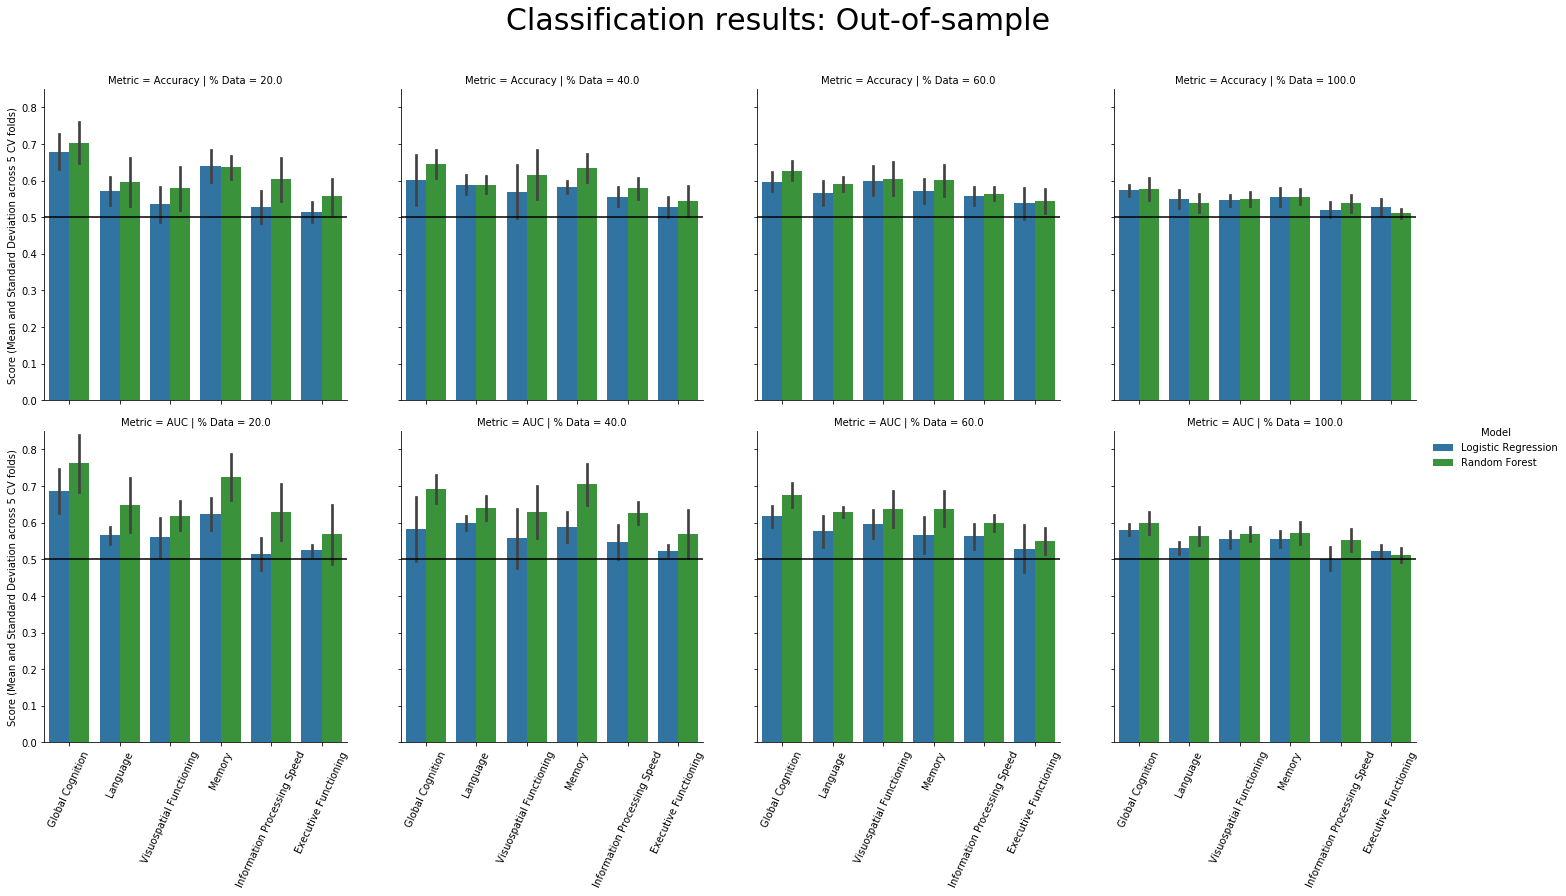

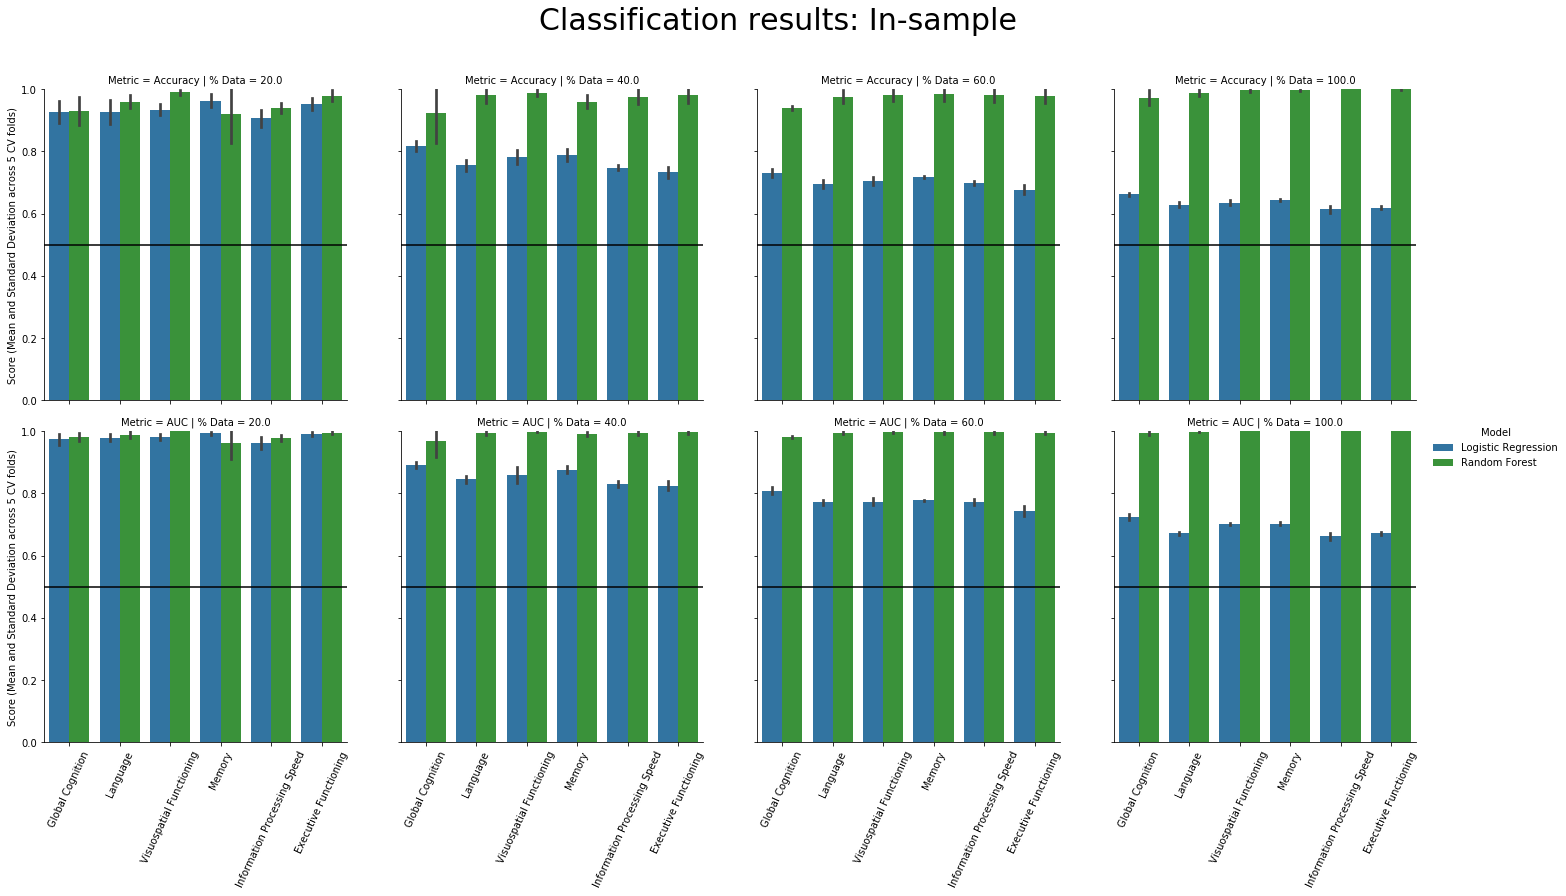

In [19]:
classification_common.plot_all_scores(scores_df_all)